In [1]:
# Import things we are going to use

from numpy import mean, linspace
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Analysis Plan

### Steps we will follow throughout this notebook

1. Import and load dataset
2. Perform basic exploratory analysis. Identify patterns, trends, gain some insight of the data
3. Manipulate data, preprocess. Cut and slice. Create sets of data for later purposes.
4. Use random forest as benchmark accuracy score without any preprocessing or feature selection
5. Find out how other algorithms work
6. Optimize and compare

In [2]:
# load dataset print first 5 lines

raw_set = pd.read_excel('credit_cleaned.xls')

# rename the columns of the dataframe as it seems that they are on the first row. Then remove the first row

raw_set.columns = [raw_set[column][0] for column in raw_set.columns]

# Remove first row

raw_set.drop(raw_set.index[0], inplace=True)

raw_set.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
# Check out the types and convert all of them to integers. This will be necessary for correlation analysis later on
print(raw_set.dtypes)

for col in raw_set.columns:
    raw_set[col] = raw_set[col].astype('int')
    
print(raw_set.dtypes)

ID                            object
LIMIT_BAL                     object
SEX                           object
EDUCATION                     object
MARRIAGE                      object
AGE                           object
PAY_0                         object
PAY_2                         object
PAY_3                         object
PAY_4                         object
PAY_5                         object
PAY_6                         object
BILL_AMT1                     object
BILL_AMT2                     object
BILL_AMT3                     object
BILL_AMT4                     object
BILL_AMT5                     object
BILL_AMT6                     object
PAY_AMT1                      object
PAY_AMT2                      object
PAY_AMT3                      object
PAY_AMT4                      object
PAY_AMT5                      object
PAY_AMT6                      object
default payment next month    object
dtype: object
ID                            int32
LIMIT_BAL                

### Start with some basic exploratory analysis 

#### Relevant questions and steps:

1. Is it binary classification or multi-class?
2. Are the classes balanced or imbalanced?
3. Are there any categorical variables that need treatment?
4. Prepare data for future models, such as scaling and/or feature extraction

In [4]:
# Let's see how many different values our target variable is comprised of, and how are they distributed

target = raw_set['default payment next month']
print(target.unique())
print(target.value_counts())

[1 0]
0    23364
1     6636
Name: default payment next month, dtype: int64


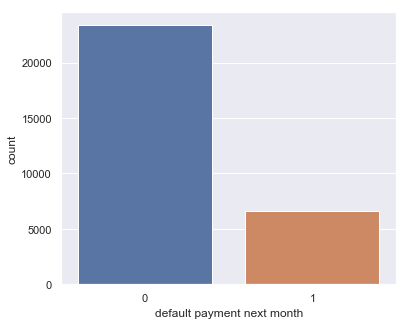

In [5]:
# Let's visualize the target label distribution 

sns.set_style(style='darkgrid')
sns.set(rc={'figure.figsize':(6, 5)})
sns.countplot(x="default payment next month", data=raw_set)

### We can see that target class is not balanced

Class `0` in fact seems to appear as 5 times as often as class `1`. This is something we should consider for two particular reasons:

1. Due to this imbalance, **accuracy** is not a reliable metric to describe model's success. So we will use **roc area under the curve** as our main metric of concern. We will keep also accuracy for monitoring as a secondary, more naive metric though.
2. The specific proportion between class `0` and `1` will be probably helpful later with logistic regression, as we can adjust classes' weights either manually or with the help of grid search.

First gender is 40.0% of the population. Second gender is 60.0% of the population


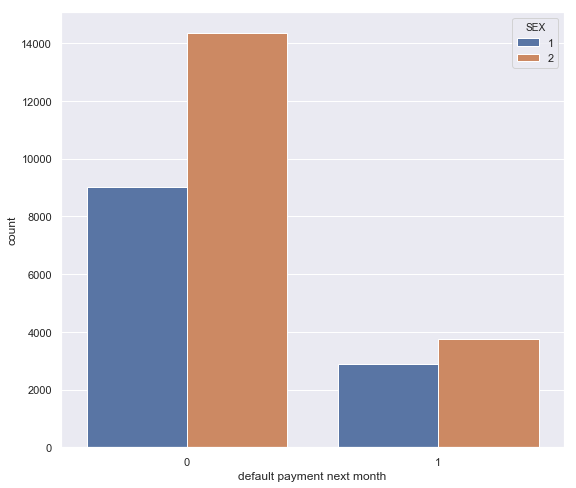

In [6]:
# Let's examine if gender plays some role to the outcome. Let's see how many different gender values exist, find distribution.

gender_dist = raw_set['SEX'].value_counts()
second_gender, first_gender = gender_dist

# As we see gender is not evenly distributed, as the second gender contains 60% of the population 

first_proportion = round(first_gender / raw_set['SEX'].shape[0], 2) * 100
second_proportion = round(100 - first_proportion, 2)

print('First gender is {}% of the population. Second gender is {}% of the population'. format(first_proportion, second_proportion))

# let's have a plot and visualize the difference on the outcome if there is one

sns.set_style(style='darkgrid')
sns.set(rc={'figure.figsize':(9, 8)})
ax = sns.countplot(x='default payment next month', hue='SEX', data=raw_set)
plt.show()

#### No Effect?

So at a first glance it does not seem that gender gives you a bigger likelihood to belong to either class, at least significantly.

Bear in mind that gender with class "2", the orange one as depicted in the graph, appears **1.5** times as frequently as gender
with class "1".

This proportion seems to be preserved in both outcomes, with some variation of course. Pay attention that on the left side
the proportion is way more recognizable than on the right side where the samples are smaller.

#### What else could we do?

In such cases and if we want make ourselves sure, we could perform a hypothesis testing and suggest as alternative hypothesis
that the gender observed values are way different than the expected ones (always proportionally). A chi-square test would be
very helpful to see, if such a claim stands, and the difference between expected and observed values, is not likely to happen by chance. 

#### Hot take

For now we will trust our vision and we will check again later. One thing we will do for sure is since gender is categorical 
variable, we will have to treat as it so. Same with `education` and `marriage` types. We will create categorical variables for them as well and if they also don't seem to provide a strong correlation with target label feature, they could be extracted or removed potentially.

In [7]:
# This is the raw dataset of all X columns, no preprocessing or feature selection. We will use this for our models later on

raw_features = raw_set.drop(columns = 'default payment next month')

raw_features.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
1,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
2,2,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,3,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,4,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,5,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


### One hot encode

As we see below we will use `one hot encode` to create two categorical columns that correspond to each gender. We do this to prevent any numerical disambiguation that could arise from interpreting these categories as numbers. Is `2` category double than `1` category or what is the actual relationship there? 

We will proceed with **Marriage** and **Education** categories as well.

In [8]:
# Create the categorical variables for 'sex', 'education' and 'marriage' categories.

#first check how many different genders are there

num_genders = raw_features['SEX'].unique()

print(num_genders)

# There is 7 education categories and 4 marriage categories

education_categories = raw_features['EDUCATION'].unique()
marriage_categories = raw_features['MARRIAGE'].unique()

print(education_categories)
print(marriage_categories)

# So now let's create categorical 'dummy' variables for these and 'sex' category and save it to a new dataframe.

raw_categorical = pd.get_dummies(raw_features, columns=['SEX', 'EDUCATION', 'MARRIAGE'])

# remove at least one column, whose value can be inferred from other columns' values. See degrees of freedom below
raw_categorical.drop(columns = ['SEX_2', 'EDUCATION_6', 'MARRIAGE_3'], inplace=True)

raw_categorical.head(5)

[2 1]
[2 1 3 5 4 6 0]
[1 2 3 0]


,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,SEX_1,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2
1,1,20000,24,2,2,-1,-1,-2,-2,3913,...,0,0,0,1,0,0,0,0,1,0
2,2,120000,26,-1,2,0,0,0,2,2682,...,0,0,0,1,0,0,0,0,0,1
3,3,90000,34,0,0,0,0,0,0,29239,...,0,0,0,1,0,0,0,0,0,1
4,4,50000,37,0,0,0,0,0,0,46990,...,0,0,0,1,0,0,0,0,1,0
5,5,50000,57,-1,0,-1,0,0,0,8617,...,1,0,0,1,0,0,0,0,1,0


## Degrees of what?

Let's examine a math concept that will help us optimize our categorical columns here. We will take for example the `EDUCATION` 
category and we will use it's perspective. We have 6 education categories, but each data point (each row) can belong only to one. Thus being part of a specific category automatically excludes this data point from the rest. 

When having such relationship, the last categorical column of this category does not provide any information gain. Since it's value can be inferred from examining the rest of the columns. For example if all previous columns of **education** from 1 to 5 have all value of `0`, then we know that the last category must always contain value of `1`. 

That's because in such situtation we may have 6 variables, but only 5 of them are **free to vary**. This statistical concept is known as [Degrees of freedom](https://en.wikipedia.org/wiki/Degrees_of_freedom_(statistics). Thus we can get rid of each last 
column of categories such as `education`, `marriage` and `sex`. In fact we can remove any column (not only the last one), but strictly **only one**.

In [9]:
# Let's check these pay columns again and see what they are made of

raw_features.columns = ['PAY_1' if column == 'PAY_0' else column for column in raw_features.columns]

for i in range (1, 7):
    print(raw_features['PAY_' + str(i)].unique())
    
# For now we don't know if these are categories, continues or discrete values, like how many days after the deadline the payment
# mode. Temporarily we will treat them as discrete values.

[ 2 -1  0 -2  1  3  4  8  7  5  6]
[ 2  0 -1 -2  3  5  7  4  1  6  8]
[-1  0  2 -2  3  4  6  7  1  5  8]
[-1  0 -2  2  3  4  5  7  6  1  8]
[-2  0 -1  2  3  5  4  7  8  6]
[-2  2  0 -1  3  6  4  7  8  5]


In [10]:
# scale data using minmax scaler, this is helpful later for KNN boosting and some other models. Store results in new DF

min_max_scaler = MinMaxScaler()
scaled_X = min_max_scaler.fit_transform(raw_categorical)
scaled_features = pd.DataFrame(scaled_X, columns=raw_categorical.columns)

scaled_features.head(5)

C:\Users\jake\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,SEX_1,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2
0,0.000000,0.010101,0.051724,0.4,0.4,0.1,0.1,0.0,0.0,0.149982,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000033,0.111111,0.086207,0.1,0.4,0.2,0.2,0.2,0.4,0.148892,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000067,0.080808,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,0.172392,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000100,0.040404,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,0.188100,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000133,0.040404,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,0.154144,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# scale per z-score standard scaler. This could be helpful for logistic regression or Gaussian Naive Bayes later. Store in DF

standard_scaler = StandardScaler()
standard_scaled_X = standard_scaler.fit_transform(raw_categorical)
standard_scaled_features = pd.DataFrame(standard_scaled_X, columns=raw_categorical.columns)

standard_scaled_features.head(5)

C:\Users\jake\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jake\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,SEX_1,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2
0,-1.731993,-1.136720,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,...,-0.810161,-0.021608,-0.738375,1.0669,-0.442752,-0.064163,-0.097063,-0.042465,1.093780,-1.066471
1,-1.731878,-0.365981,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,...,-0.810161,-0.021608,-0.738375,1.0669,-0.442752,-0.064163,-0.097063,-0.042465,-0.914261,0.937672
2,-1.731762,-0.597202,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,...,-0.810161,-0.021608,-0.738375,1.0669,-0.442752,-0.064163,-0.097063,-0.042465,-0.914261,0.937672
3,-1.731647,-0.905498,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,...,-0.810161,-0.021608,-0.738375,1.0669,-0.442752,-0.064163,-0.097063,-0.042465,1.093780,-1.066471
4,-1.731531,-0.905498,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,...,1.234323,-0.021608,-0.738375,1.0669,-0.442752,-0.064163,-0.097063,-0.042465,1.093780,-1.066471


### Correlation Analysis

Then we will remove the features, whose `pearson R` value is between **-0.15** and **0.15**, as they tend to add noise rather
than info. We will keep of course in existing dataframes all features, so we can compare and see if there is an actual difference between same models.

In [12]:
correlation_matrix = raw_set.corr()

correlation_matrix

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,1.000000,0.026179,0.018497,0.039177,-0.029079,0.018678,-0.030575,-0.011215,-0.018494,-0.002735,...,0.040351,0.016705,0.016730,0.009742,0.008406,0.039151,0.007793,0.000652,0.003000,-0.013952
LIMIT_BAL,0.026179,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.018497,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
EDUCATION,0.039177,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
MARRIAGE,-0.029079,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
AGE,0.018678,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_0,-0.030575,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.011215,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.018494,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
PAY_4,-0.002735,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614


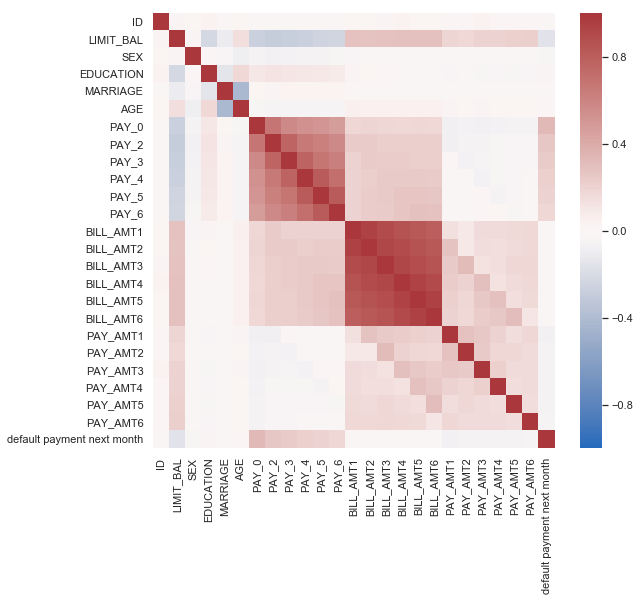

In [13]:
# Let's plot a heatmap and have a better look. The columns to the far right, is what we are mostly interested in

sns.heatmap(correlation_matrix, cmap='vlag', vmax=1, vmin=-1)

At a first glance we can conclude that only the `pay_number` type of columns (plus `LIMIT_BAL`) have something to do with the variable we are trying to predict.  

This makes sense also if we think about it. The consistency of how well the customer pays up each month, should be a good overview of what follows

##### We have to be careful though as these columns also seem to be highly correlated with each another (co-influencing each other)

So we will keep all options open, and store the different variations of columns selections in different dataframes. Then we can compare how do they work, when applied on our models.

In [14]:
# select features here, slice in order to remove Pay_amt columns, and add LIMIT_BAL column alongside PAY_0, ... PAY_6

all_pay_columns = [col for col in raw_set if 'PAY' in col][0:6]
all_pay_columns.append('LIMIT_BAL')

# in the end we have 3 new dataframes, all equipped with only 'high profile' columns. One with no scale, one minmax, one z-score

select_raw_features = raw_categorical.filter(all_pay_columns, axis = 1)
select_standard_features = standard_scaled_features.filter(all_pay_columns, axis = 1)
select_scaled_features = scaled_features.filter(all_pay_columns, axis=1)

print(select_raw_features.head(5))
print('\n')
print(select_scaled_features.head(5))
print('\n')
print(select_standard_features.head(5))

   PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  LIMIT_BAL
1      2      2     -1     -1     -2     -2      20000
2     -1      2      0      0      0      2     120000
3      0      0      0      0      0      0      90000
4      0      0      0      0      0      0      50000
5     -1      0     -1      0      0      0      50000


   PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  LIMIT_BAL
0    0.4    0.4    0.1    0.1    0.0    0.0   0.010101
1    0.1    0.4    0.2    0.2    0.2    0.4   0.111111
2    0.2    0.2    0.2    0.2    0.2    0.2   0.080808
3    0.2    0.2    0.2    0.2    0.2    0.2   0.040404
4    0.1    0.2    0.1    0.2    0.2    0.2   0.040404


      PAY_0     PAY_2     PAY_3     PAY_4     PAY_5     PAY_6  LIMIT_BAL
0  1.794564  1.782348 -0.696663 -0.666599 -1.530046 -1.486041  -1.136720
1 -0.874991  1.782348  0.138865  0.188746  0.234917  1.992316  -0.365981
2  0.014861  0.111736  0.138865  0.188746  0.234917  0.253137  -0.597202
3  0.014861  0.111736  0.138865  0.188746  0

### Now we should have at our disposal the following datasets to work with:

1. Raw dataset with all features and target variable included as they are. **raw_set**
2. Same as *raw_set*, just target variable is excluded. **raw_features**
3. Categorical values with dummy variables. **raw_categorical**
4. Scale according to min-max scaler. Mostly for KNN. **scaled_features**
5. Scale according to z-score standard scaler. Mostly for logistic regression. **standard_scaled_features**
6. Select features with higher correlation without any scaling. **select_raw_features**
7. Select features, scaled min-max. **select_scaled_features**
8. Select features, scaled by standard scaler. **select_standard_features**

Hopefully now we have couple of sets, to test and see if there is some significant boost with a specific approach or not.

### Possbile takes 

1. We can see we are dealing with two possible values, thus a binary classification problem.
2. We can also extract that class '0' appears way more frequently. So our data is imbalanced.
as a more reliable metric system than plain accuracy score. 

## Set Performance Benchmark

Apply without any exploration or preprocessing, a benchmark performance metric with random forest, in order to assess the
complexity of the data and how much can be explained from the features with a first glance.

##### Procedure

1. Random Forest classifier on a 5 Fold cross validation
2. Print and measure the average accuracy and/or roc area under the curve since we have binary classification

In [15]:
# generic function, we pass the model as first param, X_features and target column. Applies 5 Fold Cross Validation with metrics
# accuracy and auc score. After each run prints the average of these metrics (mean of 5 folds), and returns a dictionary 

def run_model(model, feature_set, target_label):
    cross_score = cross_validate(model, feature_set, target_label, scoring = ['accuracy', 'roc_auc'], cv = 5, n_jobs=-1)
    mean_accuracy, mean_roc_auc = [round(mean(cross_score['test_accuracy']), 3), round(mean(cross_score['test_roc_auc']), 3)]
    print('The model has average accuracy {} and average area under the curve {}'.format(mean_accuracy, mean_roc_auc))
    return {'accuracy': mean_accuracy, 'auc': mean_roc_auc}

In [16]:
# We will use always a specific random state in order to preserve consistency, even if we have cross validation (which we do),
# we want to be sure that features will be applied the same across our different runs of our model and have same results

rfc_model = RandomForestClassifier(random_state = 101, max_depth = 2, n_estimators = 100)
run_model(rfc_model, select_raw_features, target)

The model has average accuracy 0.813 and average area under the curve 0.75


{'accuracy': 0.813, 'auc': 0.75}

## Benchmark outcome

### First raw initial benchmarks:

1. Accuracy: **0.813**
2. Roc AUC area: **0.75**

Now from now on we will try to approximate or surpass this performance with other algorithms and models by using scaling, feature selection and hyperparameters tunin in some cases.

In [64]:
# KNN time. Function that starts and measures for a number of neighbors on given interval. Returns results for optimization

def knn_repeater(start_neighbors, stop_neighbors, X, y):
    neighbors_placeholder = [] # holds the number of neighbors used
    all_accuracies = [] # holds the accuracy achieved with that neighbor
    all_auc = [] # more importantly hold auc score with that number of neighbors

    for i in range (start_neighbors, stop_neighbors, 5):
        knn_model = KNeighborsClassifier(n_neighbors=i)
        neighbors_placeholder.append('n_' + str(i))
        metrics = run_model(knn_model, X, y)
        all_accuracies.append(metrics['accuracy'])
        all_auc.append(metrics['auc'])
        
    return {'neighbors_collection': neighbors_placeholder, 'accuracy_collection': all_accuracies, 'auc_collection': all_auc}

## Attention!

The next **3** code blocks contain attempts, regarding the best number of nearest neighbors, as well as examining the
potential impact of scaling the data (minmax in this case) and/or feature selection performance. 

### This will take a lot of time running! Luckily you can skip!

We have run these blocks for you and hardcoded the actual values that come from these functions, after these blocks. The results are depicted on the line charts below (after these 3 blocks always). 

If for any reason you would like to execute them, feel free. Each block takes approximatelly **5-6 mins** to run so get yourself a coffee!

## Next recommended step:

Run the block with the three dictionaries after reading this line. There is a big `HERE!` comment on top of it.

In [65]:
# Feel free to skip, this block will take quite some time. KNN multiply neighbors with values: 5, 10, 15, 20, 25. Raw features

knn_scores = knn_repeater(5, 26, raw_features, target)
knn_scores

The model has average accuracy 0.747 and average area under the curve 0.594
The model has average accuracy 0.769 and average area under the curve 0.62
The model has average accuracy 0.768 and average area under the curve 0.632
The model has average accuracy 0.774 and average area under the curve 0.637
The model has average accuracy 0.773 and average area under the curve 0.643


{'neighbors_collection': ['n_5', 'n_10', 'n_15', 'n_20', 'n_25'],
 'accuracy_collection': [0.747, 0.769, 0.768, 0.774, 0.773],
 'auc_collection': [0.594, 0.62, 0.632, 0.637, 0.643]}

In [66]:
# Skip if you like. Same as before. Features are scaled by minmax

knn_scaled_scores = knn_repeater(5, 26, scaled_features, target)
knn_scaled_scores

The model has average accuracy 0.787 and average area under the curve 0.677
The model has average accuracy 0.801 and average area under the curve 0.697
The model has average accuracy 0.804 and average area under the curve 0.704
The model has average accuracy 0.803 and average area under the curve 0.708
The model has average accuracy 0.804 and average area under the curve 0.711


{'neighbors_collection': ['n_5', 'n_10', 'n_15', 'n_20', 'n_25'],
 'accuracy_collection': [0.787, 0.801, 0.804, 0.803, 0.804],
 'auc_collection': [0.677, 0.697, 0.704, 0.708, 0.711]}

In [67]:
# skip if you like, same. Data is scaled, and top-primed features are selected

knn_selected_scores = knn_repeater(5, 26, select_scaled_features, target)
knn_selected_scores

The model has average accuracy 0.799 and average area under the curve 0.7
The model has average accuracy 0.811 and average area under the curve 0.727
The model has average accuracy 0.813 and average area under the curve 0.736
The model has average accuracy 0.815 and average area under the curve 0.742
The model has average accuracy 0.816 and average area under the curve 0.743


{'neighbors_collection': ['n_5', 'n_10', 'n_15', 'n_20', 'n_25'],
 'accuracy_collection': [0.799, 0.811, 0.813, 0.815, 0.816],
 'auc_collection': [0.7, 0.727, 0.736, 0.742, 0.743]}

In [68]:
# HERE!!!
# immitate block in case you skipped three above. These will be the actual results if you run above blocks.

# score collection observed from running above models with non-scaled, all-columns data as features
knn_scores_fake = {
    'neighbors_collection': ['n_5', 'n_10', 'n_15', 'n_20', 'n_25'],
    'accuracies_collection': [0.747, 0.769, 0.768, 0.774, 0.773],
    'auc_collection': [0.594, 0.62, 0.632, 0.637, 0.643]
}

# score collection observed from running above models with minmax scaled data, all columns data as features
knn_scaled_scores_fake = {
    'neighbors_collection': ['n_5', 'n_10', 'n_15', 'n_20', 'n_25'],
    'accuracies_collection': [0.787, 0.801, 0.804, 0.803, 0.804],
    'auc_collection': [0.677, 0.697, 0.704, 0.708, 0.711]
}

# score collection observed from running above models with minmax scaled data and featured columns
knn_selected_fake = {
    'neighbors_collection': ['n_5', 'n_10', 'n_15', 'n_20', 'n_25'],
    'accuracies_collection': [0.799, 0.811, 0.813, 0.815, 0.816],
    'auc_collection': [0.7, 0.727, 0.736, 0.742, 0.743]
}

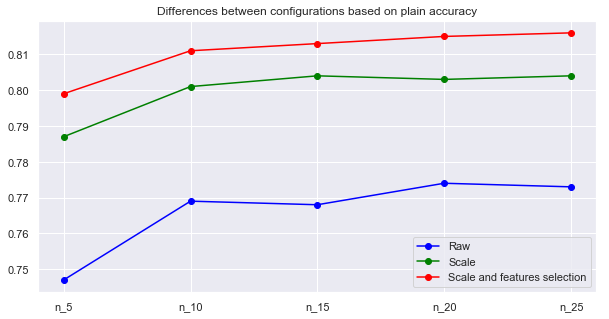

In [69]:
# Let's try and plot the differences 

plt.figure(num = 3, figsize=(10, 5))
plt.title('Differences between configurations based on plain accuracy')
plt.plot(knn_scores_fake['neighbors_collection'], knn_scores_fake['accuracies_collection'], color='blue', marker='o')
plt.plot(knn_scores_fake['neighbors_collection'], knn_scaled_scores_fake['accuracies_collection'], color='green', marker='o')
plt.plot(knn_scores_fake['neighbors_collection'], knn_selected_fake['accuracies_collection'], color='red', marker='o')

plt.legend(['Raw', 'Scale', 'Scale and features selection'])

plt.show()

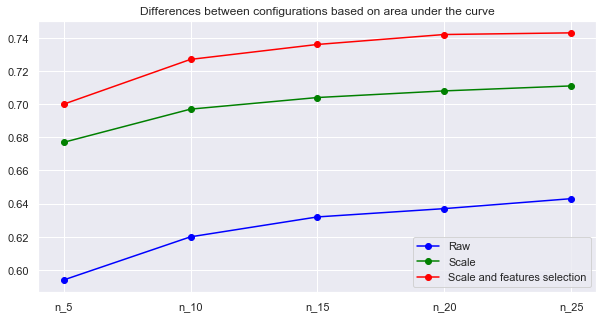

In [70]:
# Let's try and plot these differences with auc metric now

plt.figure(num = 3, figsize=(10, 5))
plt.title('Differences between configurations based on area under the curve')
plt.plot(knn_scores_fake['neighbors_collection'], knn_scores_fake['auc_collection'], color='blue', marker='o')
plt.plot(knn_scores_fake['neighbors_collection'], knn_scaled_scores_fake['auc_collection'], color='green', marker='o')
plt.plot(knn_scores_fake['neighbors_collection'], knn_selected_fake['auc_collection'], color='red', marker='o')

plt.legend(['Raw', 'Scale', 'Scale and features selection'])

plt.show()

## Plot overview

As we can see from the plots above, scaling does indeed have an immediate impact on both metrics (and in roc area under the curve, which is our primary metric, even more significantly).

The feature selection at this point it seems that it helps in both metrics slightly but also consistently. Thus we can take for KNN the *scaled and pruned features version* as basis and search for the optimal number of **N Neighbors**. 

After a lot of tuning and some binary search, we end up with best knn fit for test set, the one with **200 nearest neighbors**. See below for more but all in all:

#### KNN Benchmark with 200 nearest neighbors:

1. accuracy: **0.816**
2. Roc Auc score: **0.761**

In [71]:
# Let' see this in action

knn_model = KNeighborsClassifier(n_neighbors=200)
run_model(knn_model, select_scaled_features, target)

The model has average accuracy 0.816 and average area under the curve 0.761


{'accuracy': 0.816, 'auc': 0.761}

## Logistic regression tryouts

In the following blocks, we will try to optimize the best logistic regression fit. We will try up:

1. Raw features and non preprocessed data
2. Standard scaled data
3. Find the best class_weight balance params to optimize both accuracy and auc score

**Note**: The last part is derived from the fact that our classes are not evenly distributed, thus we will try out some different values for `class_weight` parameters. In the end, we will apply a grid search to find the best params by these metrics programmatically.

In [72]:
# Logistic regression, we set random state to achieve consistent results also here
lg_model = LogisticRegression(random_state=101, max_iter=300)

In [73]:
# all features, no preprocessing, first try

run_model(lg_model, raw_features, target)

The model has average accuracy 0.779 and average area under the curve 0.662


{'accuracy': 0.779, 'auc': 0.662}

In [74]:
# Select the z-score standardized features and see if there is a significance impact. All features here are selected

run_model(lg_model, standard_scaled_features, target)

The model has average accuracy 0.81 and average area under the curve 0.723


{'accuracy': 0.81, 'auc': 0.723}

In [75]:
# try out some custom weights and see how it goes.We will try the actual proportions of our predicted variable

lg_model = LogisticRegression(random_state=101, max_iter=300, class_weight={0: 0.78, 1: 0.22})
run_model(lg_model, standard_scaled_features, target)

The model has average accuracy 0.782 and average area under the curve 0.723


{'accuracy': 0.782, 'auc': 0.723}

In [76]:
# try out balanced weights

lg_model = LogisticRegression(random_state=101, max_iter=300, class_weight='balanced')
run_model(lg_model, select_scaled_features, target)

The model has average accuracy 0.675 and average area under the curve 0.715


{'accuracy': 0.675, 'auc': 0.715}

### Class weight take out

At a first glance, looks like the *balanced* `class_weight` failed miserably, but actually provided the best area under the curve (with a weak, nearly non-existent margin of course).

#### Let's try to find the best params programmatically instead of manually. 

Let's do some grid search here.

In [77]:
# Let's find best parameters by applying grid search, we will try to optimize class_weight by both accuracy and roc_auc score

weights = linspace(0.05, 0.95, 20) # split into 20 pieces of 0.05 distance each

def find_grid_search_best(model, weight_list, scoring, folds, X, y):
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid={'class_weight': [{0: x, 1: 1.0 - x} for x in weight_list]},
        scoring = scoring,
        cv = folds
        )

    grid_result = grid_search.fit(X, y)
    best_params = grid_result.best_params_
    print(best_params['class_weight'])
    return best_params['class_weight']

In [81]:
# ATTENTION! this could take couple of minutes, but worth the shot

# define standard model to find best grid params for
lg_model = LogisticRegression(random_state=101, max_iter=300, solver='lbfgs')

# find best params as above but with auc score in mind
lg_roc_best = find_grid_search_best(lg_model, weights, 'roc_auc', 5, select_scaled_features, target)

{0: 0.4289473684210526, 1: 0.5710526315789475}


In [82]:
# tune both models with their respective params and see the outcome

lg_tuned_auc = LogisticRegression(random_state=101, max_iter=300, solver='lbfgs', class_weight=lg_roc_best)

In [83]:
run_model(lg_tuned_auc, standard_scaled_features, target)

The model has average accuracy 0.816 and average area under the curve 0.723


{'accuracy': 0.816, 'auc': 0.723}

## Logistic regression takeaways

As we see after performing grid search,auc best tuning parameters affect accuracy negatively and by a lot. But since our current data is heavily imbalanced, we care more about how we classify the `non-dominating` predicting class.

Having said that we will take as our *logistic regression champion* the model `lg_tuned_accuracy` since we take a look at both metrics and auc performance difference is almost non-detectable.

In [84]:
# Let's create a gaussian naive model
naive_model = GaussianNB(class)

In [85]:
# Let's try out the naive bayes, since it runs fast we will cross-check all  possible data we have created

possible_features = {
    'raw_features': raw_features, # no scale, no preprocessing, X features as they come from dataset
    'with_dummy': raw_categorical, # dummy variables for categorical columns
    'prime_raw': select_raw_features, # top 7 features, no scale
    'scaled_raw': standard_scaled_features, # z-score scaling, no feature selection
    'scaled_prime_features': select_scaled_features # top 7 features, z-score scaled
 }

# run a model with multiple different X_features, return the scores as a list of dictionaries, it should be quick to run.

def run_bayes_models(model, X_info, y):
    feature_list_scores = []
    for (feature_desc, feature_set) in possible_features.items():
        scoring = run_model(model, feature_set, y)
        feature_list_scores.append({feature_desc: scoring})
    print(feature_list_scores)
    return feature_list_scores

In [86]:
# Let's have a look inside all possible scenarios, also gather stats to depict later on

naive_model_summary_scores = run_bayes_models(naive_model, possible_features, target)

The model has average accuracy 0.384 and average area under the curve 0.672
The model has average accuracy 0.384 and average area under the curve 0.672
The model has average accuracy 0.78 and average area under the curve 0.684
The model has average accuracy 0.279 and average area under the curve 0.736
The model has average accuracy 0.802 and average area under the curve 0.737
[{'raw_features': {'accuracy': 0.384, 'auc': 0.672}}, {'with_dummy': {'accuracy': 0.384, 'auc': 0.672}}, {'prime_raw': {'accuracy': 0.78, 'auc': 0.684}}, {'scaled_raw': {'accuracy': 0.279, 'auc': 0.736}}, {'scaled_prime_features': {'accuracy': 0.802, 'auc': 0.737}}]


['raw_features', 'with_dummy', 'prime_raw', 'scaled_raw', 'scaled_prime_features']
[0.384, 0.384, 0.78, 0.279, 0.802]
[0.672, 0.672, 0.684, 0.736, 0.737]


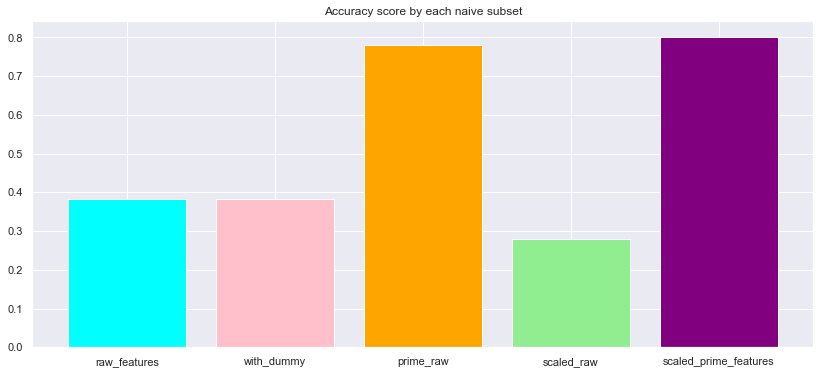

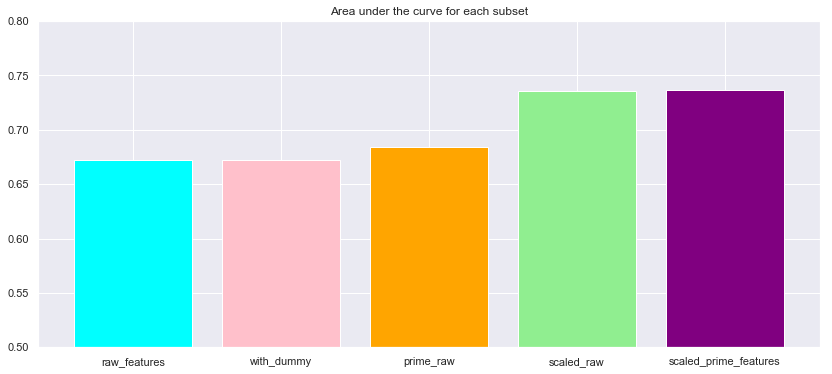

In [87]:
features_descriptions = list(possible_features.keys())
naive_accuracies = [list(score.values())[0]['accuracy'] for score in naive_model_summary_scores] # get all accuracy scores
naive_auc_scores = [list(score.values())[0]['auc'] for score in naive_model_summary_scores] # get auc scores at once

print(features_descriptions)
print(naive_accuracies)
print(naive_auc_scores)

# Let's plot and find the best set for our naive bayes classifier

color_palette = ['cyan', 'pink', 'orange', 'lightgreen', 'purple']
fig = (14, 6)

plt.figure(figsize= fig)
plt.title('Accuracy score by each naive subset')
plt.bar(features_descriptions, naive_accuracies, color= color_palette)

plt.figure(figsize= fig)
plt.title('Area under the curve for each subset')
plt.ylim(0.5, 0.8)
plt.bar(features_descriptions, naive_auc_scores, color= color_palette)

plt.show()

## Naive Bayes takes

As plot suggests, selecting only relevant features seems to have a significant impact in accuracy, but they also slightly help when the metric is **auc**, which is our main metric. Scaling helps also in both cases so we will take this one out of the bag, to represent **naive bayes** into comparison with the rest of algorithms.

#### Note:

Because some datasets contain negative values, we couldn't use a **Multinomial Naive Bayes** classifier out of the box. We could scale our dataset in **min-max** scale, and then run of course.

Instead we used **Gaussian Bayes** classifier, which assumes normal distribution on values. This can work for raw negative values on datasets, but also very well with **z-score** scale. Both classifiers provide almost identical results in our case though. 

## Last Attempt, Beat the House!

Closing, we will try to beat the competition and apply some grid search in our random forest model and see where this goes, since they only shot we gave to a random forest was without real tuning or pre-processing.

### Attention! Next block will take some time. 

Results will be faked at the next block as well. **Feel free, to skip** 

In [89]:
# applying grid search for random forest, This could take a while. Feel free to skip, you can find the results on later blocks

grid_search_forest = GridSearchCV(
    estimator = RandomForestClassifier(random_state=101),
    param_grid = {
        'n_estimators': [200, 500],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'criterion': ['gini', 'entropy']
    },
    scoring = 'roc_auc',
    cv = 5
)

grid_result = grid_search_forest.fit(select_raw_features, target)
grid_result.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 200}

In [90]:
# These parameters come from the grid search we applied at the above block
rfc_model = RandomForestClassifier(random_state=101, max_depth=8, n_estimators=200, criterion='entropy')

In [91]:
run_model(rfc_model, select_raw_features, target)

The model has average accuracy 0.82 and average area under the curve 0.766


{'accuracy': 0.82, 'auc': 0.766}

## New Support Vector Machine Update Part

During the following blocks we will use couple of support vector classifiers and see how they perform in our circumstance.
We will use sequentially:

1. Linear support vector classifier
2. Polynomial kernel
3. Radial basis function

We will try to optimize and tweak some parameters either by applying some kind of cross validation search (either `random` or `grid` we will find out), or by following some best tips and practices from [sci-kit learn](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use) when working with support vector machines.

To mention the most fundamentals.

1. we will use the scaled data for all try outs since it is highly recommended and gives better performance
2. We will adjust the class weight and set it to **balanced** since we deal with imbalanced dataset

In [18]:
# Have a look at linear classifier, it should run faster, we will use standard C value here, scaled data and prime features
# We havn't applied balanced weights on classes yet

svc_model = SVC(kernel='linear', C=1.0)
run_model(svc_model, select_scaled_features, target)

The model has average accuracy 0.804 and average area under the curve 0.693


{'accuracy': 0.804, 'auc': 0.693}

In [19]:
# Let's tweak the class weight here and see if there is an improvement from previous result

svc_model = SVC(kernel='linear', C=1.0, class_weight='balanced')
run_model(svc_model, select_scaled_features, target)

The model has average accuracy 0.789 and average area under the curve 0.712


{'accuracy': 0.789, 'auc': 0.712}

**Hooray!!**. It seems there was some slight improvement (approximately 2%), so we will adopt from now on the class weight
attribute as balanced. We take this as our **linear champ** with `roc_auc` score around **0.712** into our svm comparison in the end.

Let's proceed with polynomials and radial kernels. Next blocks are going to take approx. 5-6 mins each to run, so feel free to skip them. Results will be hardcoded at the end of them. (You can still examine the parameters tweaking and so on of course).

In [20]:
#After some tweaking and more try outs I ended up with the following params for polynomial model. 3rd degree polynomial with
# following properties

random_polynomial_model = SVC(kernel='poly', class_weight='balanced', gamma=2.0, C=1, coef0=0.5)
run_model(random_polynomial_model, select_scaled_features, target)

# Gives auc: 0.734

The model has average accuracy 0.774 and average area under the curve 0.734


{'accuracy': 0.774, 'auc': 0.734}

In [21]:
# Let's see how it behaves on a higher degree for the sake of experimentation with same params, out of curisioty

random_polynomial_model = SVC(kernel='poly', class_weight='balanced', gamma=2.0, degree=4, C=1, coef0=0.5)
run_model(random_polynomial_model, select_scaled_features, target)

# Gives auc: 0.724 so it is a slight decline. But we have a good grasp of what the order of magnitude result a polynomial gives

The model has average accuracy 0.772 and average area under the curve 0.724


{'accuracy': 0.772, 'auc': 0.724}

### Polynomials vantage point

So as we saw polynomials tend to be a bit more performant than linear support vector machines. That is to be expected though
since our data should have a serious overlap effect regarding our classes and observations. 

That is why, an assumption that a radial kernel would provide more accurate results, it is considerable. Let's see also if it's
true.

In [45]:
# ATTENTION! It is probable that this block will run for couple of hours, depending on your PC Performance, we try to find
# the best optimization params for a radial kernel svc. Results in the comments after function. Feel free to examine the code
# and skip though.

grid_search_rbf = GridSearchCV(
    estimator = SVC(kernel='rbf', class_weight='balanced'),
    param_grid = {
        'C': [0.1, 0.5, 1],
        'gamma': [0.1, 0.5, 1.0, 2.0]
    },
    scoring = 'roc_auc',
    cv = 5
)

grid_rbf_result = grid_search_rbf.fit(select_scaled_features, target)
grid_rbf_result.best_params_

# Best params is C:1 and gamma: 2.0 Let's see how it behaves and if it's more performant than our polynomial champ.

{'C': 1, 'gamma': 2.0}

In [23]:
# apply changes from grid search with C = 1 and gamma = 2.0

best_rbf_grid_model = SVC(kernel='rbf', class_weight='balanced', C=1, gamma=2.0)
run_model(best_rbf_grid_model, select_scaled_features, target)

The model has average accuracy 0.774 and average area under the curve 0.739


{'accuracy': 0.774, 'auc': 0.739}

Since the biggest possible gamma is selected, it leaves an implication that we havn't found the optimal gamma and it could be actually bigger than 2. Trying out some parameters it shows that this is atually the case! As we can see in the following code after some try outs, we get a better `auc` score for gamma equal to **3.0**

In [24]:
# Apply gamma equal to 3.0

bigger_gamma_model = SVC(kernel='rbf', class_weight='balanced', C=1, gamma=3.0)
run_model(bigger_gamma_model, select_scaled_features, target)

The model has average accuracy 0.775 and average area under the curve 0.744


{'accuracy': 0.775, 'auc': 0.744}

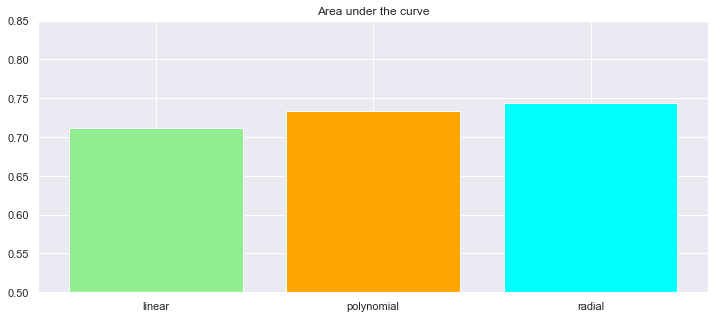

In [26]:
# Let's have some support vector machine champs comparison!

kernels= ['linear', 'polynomial', 'radial']
svc_auc_scores = [0.712, 0.734, 0.744]

fig = (12, 5)
color_palette = ['lightgreen', 'orange', 'cyan']

plt.figure(figsize= fig)
plt.title('Area under the curve')
plt.ylim(0.5, 0.85)
plt.bar(kernels, svc_auc_scores, color= color_palette)

plt.show()

Seems the radial kernel has a slight advantage in our main metric and will be selected to represent support vector machines into our final model comparison!

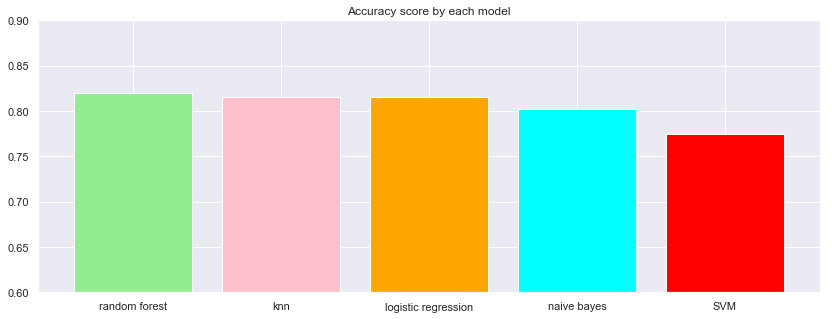

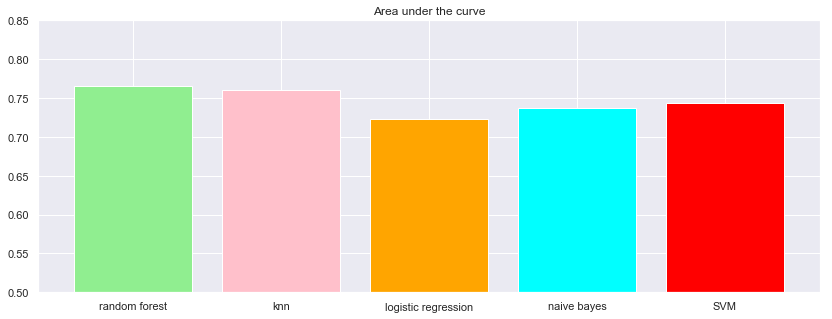

In [28]:
# Faking all three models scores. These are the actual best scores that come for both metrics, if we run all blocks above
# We didn't take the scores programmatically due to significant amount of time need to run all models

models = ['random forest', 'knn', 'logistic regression', 'naive bayes', 'SVM']
accuracies = [0.82, 0.816, 0.816, 0.802, 0.775]
auc_scores = [0.766, 0.761, 0.723, 0.737, 0.744]

fig = (14, 5)
color_palette = ['lightgreen', 'pink', 'orange', 'cyan', 'red']

plt.figure(figsize= fig)
plt.title('Accuracy score by each model')
plt.ylim(0.6, 0.9)
plt.bar(models, accuracies, color= color_palette)

plt.figure(figsize= fig)
plt.title('Area under the curve')
plt.ylim(0.5, 0.85)
plt.bar(models, auc_scores, color= color_palette)

plt.show()

### Quick note on SVC:

It seems to fall behind in accuracy, but that makes sense since we didn't optimize for that metric and it doesn't really bother us at this point.

It stays competitive and has a slight edge on `logistic regression` and `naive bayes` in this case, but still is a bit lower than a random forest and a good knn. That is a bit odd since the **support vector radial basis function** works as a weighted knn classifier. Not sure why this is happening. Maybe for the existing dataset is more preferable to apply **democracy knn** and every neighbor to have the same importance, but it's a nice food for thaught and experimentation.

# Conclusion

We can safely express that there is no significant difference in evaluating performance between our random forest, knn and logistic regression models when it comes to accuracy. Take note that both plots are *zoomed* in order to make differences a bit more obviously.

This is something we can tell from the actual numbers without visualization at all, since all scores tend to gather around
**0.80 - 0.83**. Always when it comes to plain accuracy.

However, since our classes are not evenly distributed, a look at the **area under the curve** would be a more reliable metric. There we found candidate models to fall in range of **0.72 - 0.77** and thus there is some slight edge that favors specific models in our particular set.

If we want to be accurate, **random forest with grid search best parameters** seem to produce slightly better **accuracy** and **auc**. 

While **KNN with 200 nearest neighbors, with 7 main features, all scaled between 0 and 1**, seem to be right up there with both metrics.

**Logistic regression best params** give a competitive mark on accuracy field, but feels like **falling a bit behind** when **auc** score comes into play in comparison to the previous two models. 

**Naive Bayes** slightly behind best models in both metrics.

### Last Note:

We used for all models a **5 fold cross validation**, primarily our metric score was **area under the curve** due to imbalanced data we've been dealt with, and least **accuracy**. Of course more metrics such as **f1 score** were considered, but we chose AUC as *one metric to rule them all* situation. 

All scores for both metrics are **averages** of each K-fold cross validation process and **not the max** or the best score, as we strive for consistent results and not results that will vary depending on random data selection (which also explains why we used specific *random states* in almost all models, whenever possible).